In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the dataset
file_path = "Compost Data.csv"  # Ensure this file is uploaded
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print("Dataset file not found. Please upload 'Compost Data.csv'.")
    exit()

# Display dataset structure
display(df.head())
display(df.info())

,Day,Temperature,MC(%),pH,C/N Ratio,Ammonia(mg/kg),Nitrate(mg/kg),TN(%),TOC(%),EC(ms/cm),OM(%),T Value,GI(%),Score
0,0,35.463,60.0000,5.7345,26.7755,2515.0,325.49,1.80632,48.365121,1.7846,83.381469,1.000000,32.8821,28.042095
1,3,41.866,56.8814,7.1327,23.0494,3449.1,302.42,1.92498,44.369634,2.4366,76.493249,0.860839,39.4615,36.185328
2,6,59.134,53.0847,7.9646,20.4697,5197.6,243.40,1.83675,37.597721,3.0118,64.818472,0.764494,30.5469,37.074037
3,9,53.119,49.4237,8.1770,18.7500,1940.1,203.99,1.78550,33.478125,3.1566,57.716287,0.700267,63.1219,51.246933
4,12,38.955,45.2203,8.0177,17.0303,814.4,200.52,1.91893,32.679954,3.5596,56.340240,0.636040,79.4691,59.698282


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Day             452 non-null    int64  
 1   Temperature     452 non-null    float64
 2   MC(%)           452 non-null    float64
 3   pH              452 non-null    float64
 4   C/N Ratio       452 non-null    float64
 5   Ammonia(mg/kg)  452 non-null    float64
 6   Nitrate(mg/kg)  452 non-null    float64
 7   TN(%)           452 non-null    float64
 8   TOC(%)          452 non-null    float64
 9   EC(ms/cm)       452 non-null    float64
 10  OM(%)           452 non-null    float64
 11  T Value         452 non-null    float64
 12  GI(%)           452 non-null    float64
 13  Score           452 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 49.6 KB


None

In [3]:
# Handle missing values
df.fillna(df.median(), inplace=True)


In [4]:
# Check for outliers using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
df = df[~outlier_mask.any(axis=1)]  # Remove rows with outliers

In [5]:
# Select relevant features and target variable
features = ['Day', 'Temperature', 'MC(%)', 'pH', 'C/N Ratio', 'Ammonia(mg/kg)',
            'Nitrate(mg/kg)', 'TN(%)', 'TOC(%)', 'EC(ms/cm)', 'OM(%)', 'T Value', 'GI(%)']
target = 'Score'

In [7]:
# Standardizing the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

joblib.dump(scaler, "scaler.pkl")  # Save the fitted scaler


# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df[target], test_size=0.2, random_state=42)

In [8]:
# Train models and tune hyperparameters
models = {
    "Linear Regression": LinearRegression(),
    "SGD Regressor": SGDRegressor(max_iter=1000, tol=1e-3, random_state=42),
    "Decision Tree": GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid={'max_depth': [3, 5, 10]}, cv=3),
    "Random Forest": GridSearchCV(RandomForestRegressor(random_state=42), param_grid={'n_estimators': [50, 100, 200]}, cv=3)
}


In [9]:
# Store MSE values
mse_results = {}
best_model = None
lowest_mse = float("inf")

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_results[model_name] = mse
    print(f"{model_name} - MSE: {mse:.4f}, R²: {r2_score(y_test, y_pred):.4f}")
    
    # Save the best model
    if mse < lowest_mse:
        lowest_mse = mse
        best_model = model

Linear Regression - MSE: 0.0000, R²: 1.0000
SGD Regressor - MSE: 0.0117, R²: 0.9999
Decision Tree - MSE: 9.9047, R²: 0.9533
Random Forest - MSE: 3.7165, R²: 0.9825


Best model saved as 'best_model.pkl'


,Model,MSE
0,Linear Regression,1.496111e-16
1,SGD Regressor,1.168560e-02
2,Decision Tree,9.904738e+00
3,Random Forest,3.716522e+00


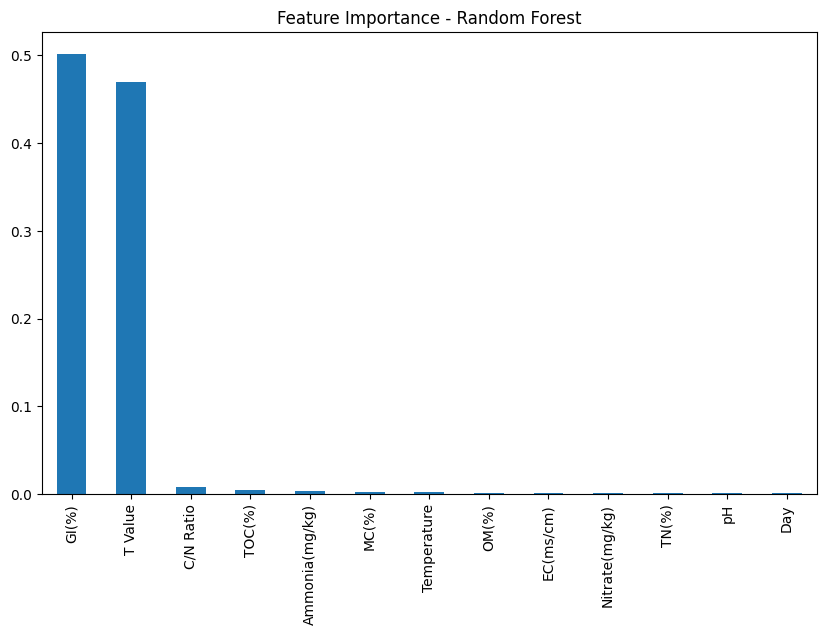

In [10]:
# Save the best model
if best_model:
    joblib.dump(best_model, "best_model.pkl")
    print("Best model saved as 'best_model.pkl'")

# Compare MSE values
mse_df = pd.DataFrame(list(mse_results.items()), columns=["Model", "MSE"])
display(mse_df)

# Plot feature importance for Random Forest
if "Random Forest" in models:
    best_rf = models["Random Forest"].best_estimator_
    feature_importances = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title("Feature Importance - Random Forest")
    plt.show()


In [11]:
# Load and test the saved model
loaded_model = joblib.load("best_model.pkl")
example_input = X_test[0].reshape(1, -1)
predicted_score = loaded_model.predict(example_input)
print(f"Example prediction: {predicted_score[0]:.4f}")


Example prediction: 28.8666


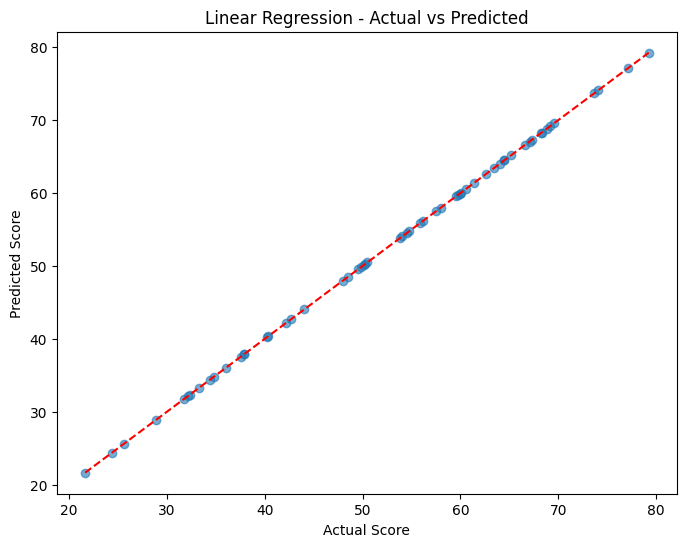

In [12]:
# Plot Linear Regression Scatter Graph
plt.figure(figsize=(8, 6))
y_pred_lr = models["Linear Regression"].predict(X_test)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Linear Regression - Actual vs Predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.show()
